In [1]:
import ecle
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint, LambdaCallback
from sklearn.metrics import log_loss
# import tensorflow as tf
# import tensorflow_hub as hub

Using TensorFlow backend.


In [24]:
import flair
import flair.datasets
from flair.data import MultiCorpus
wiki_ner = flair.datasets.WIKINER_ENGLISH()
wiki_nut = flair.datasets.WNUT_17()
imdb = flair.datasets.IMDB()
conll = flair.datasets.CONLL_2000()
multi = MultiCorpus([conll, wiki_ner, wiki_nut, imdb])
sents = [i.to_plain_string() for i in multi.train+multi.dev+multi.test]
# with open("data/wikisents3.txt", 'r') as f:
#     sents = f.readlines()

2019-11-07 00:40:18,197 Reading data from /home/jmf/.flair/datasets/ud_english
2019-11-07 00:40:18,198 Train: /home/jmf/.flair/datasets/ud_english/en_ewt-ud-train.conllu
2019-11-07 00:40:18,199 Test: /home/jmf/.flair/datasets/ud_english/en_ewt-ud-test.conllu
2019-11-07 00:40:18,200 Dev: /home/jmf/.flair/datasets/ud_english/en_ewt-ud-dev.conllu
2019-11-07 00:40:28,437 Reading data from /home/jmf/.flair/datasets/wikiner_english
2019-11-07 00:40:28,438 Train: /home/jmf/.flair/datasets/wikiner_english/aij-wikiner-en-wp3.train
2019-11-07 00:40:28,439 Dev: None
2019-11-07 00:40:28,439 Test: None
2019-11-07 00:41:24,626 Reading data from /home/jmf/.flair/datasets/wnut_17
2019-11-07 00:41:24,628 Train: /home/jmf/.flair/datasets/wnut_17/wnut17train.conll
2019-11-07 00:41:24,629 Dev: /home/jmf/.flair/datasets/wnut_17/emerging.dev.conll
2019-11-07 00:41:24,630 Test: /home/jmf/.flair/datasets/wnut_17/emerging.test.annotated
2019-11-07 00:41:26,312 Reading data from /home/jmf/.flair/datasets/imdb
2

In [27]:
# sents = [i.to_plain_string() for i in multi.train+multi.dev+multi.test]

In [28]:
prep = ecle.Preprocessor(num_stopwords=20)



np.random.shuffle(sents)
# sents = sents[:10000]
num_test = 4000
sents_train, sents_test = sents[:-num_test], sents[-num_test:]
prep.fit(sents_train, progbar=True)
from ecle.pretraining import MaskedLanguagePretrainer
mlp = MaskedLanguagePretrainer(preprocessor=prep, base_args={"preprocessor":prep})

100%|██████████| 204790/204790 [00:59<00:00, 3462.61it/s]


Tensor("ecle_inp_3:0", shape=(?, 128), dtype=float32) []
[<tf.Tensor 'pretraining_final_dense_3/Softmax:0' shape=(?, 10000) dtype=float32>]


In [4]:
mlp.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ecle_inp (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
ecle_embedding (Embedding)      (None, 128, 32)      2816        ecle_inp[0][0]                   
__________________________________________________________________________________________________
ecle_c1 (Conv1D)                (None, 128, 256)     24832       ecle_embedding[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 256)     0           ecle_c1[0][0]                    
__________________________________________________________________________________________________
ecle_c2 (C

In [29]:
mlp.model.compile('sgd', 'categorical_crossentropy')

In [34]:
# remove bad strings
sents_train_clean = []
sents_test_clean = []
for example in sents_train:
    sp = [tok.strip() for tok in example.split(" ") if tok.strip() != ""]
    if len(sp) < 2:
        continue
    # normalize to see what we can replace
    normed = [prep.scrub(tok) for tok in sp]
    # see which tokens are in the vocabulary
    replaceable_tokens = [
        (t, i) for i, t in enumerate(normed) if t in prep.token_dict
    ]
    if len(replaceable_tokens) > 0:
        sents_train_clean.append(example)
for example in sents_test:
    sp = [tok.strip() for tok in example.split(" ") if tok.strip() != ""]
    if len(sp) < 2:
        continue
    # normalize to see what we can replace
    normed = [prep.scrub(tok) for tok in sp]
    # see which tokens are in the vocabulary
    replaceable_tokens = [
        (t, i) for i, t in enumerate(normed) if t in prep.token_dict
    ]
    if len(replaceable_tokens) > 0:
        sents_test_clean.append(example)

In [ ]:
# # get the tfhub reps
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
# embed = hub.Module(module_url)

# input_placeholder = tf.placeholder(tf.string, shape=(None))
# embedding_layer = embed(input_placeholder)
# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
#     session.run(tf.tables_initializer())
#     y_train = np.zeros((len(sents_train), 512))
#     y_test = np.zeros((len(sents_test), 512))
#     for n, d in enumerate(sents_train):
#         y_train[n] = session.run(embedding_layer,
#                                  feed_dict={input_placeholder: [d]})
#     for n, d in enumerate(sents_test):
#         y_test = session.run(embedding_layer,
#                              feed_dict={input_placeholder: [d]})

In [5]:
# from keras.layers import Input, SeparableConv1D, Conv1D, MaxPooling1D, Lambda, Multiply
# from keras.layers import Dropout, Dense, Embedding, Dot, Concatenate, Reshape, Add, Average
# from keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Permute, RepeatVector, Flatten
# from keras.layers import BatchNormalization
# from keras.layers.wrappers import TimeDistributed
# from keras.regularizers import l1_l2
# from keras.optimizers import Adam, RMSprop, SGD
# from keras.models import Model, load_model
# from keras.initializers import TruncatedNormal
# from keras.constraints import MinMaxNorm
# import keras.backend as K
# import tensorflow as tf

# ecle_base = ecle.ECLEModelBase(preprocessor=prep)

# new_conv = Conv1D(128, 3, padding="same", name="words", activation="tanh")(
#     ecle_base.embedder.output
# )
# new_conv = Dropout(0.25)(new_conv)
# # add attention heads
# n_attention_heads = 4
# new_conv_shape = int(new_conv.shape[1])
# att_heads = []
# for head_num in range(n_attention_heads):
#     att = Permute((2, 1))(new_conv)
#     att = Dense(new_conv_shape, activation="softmax", name=f"att_{head_num}")(att)
#     att = Permute((2, 1))(att)
#     att_out = Multiply()([new_conv, att])
#     att_heads.append(att_out)
# cat = Concatenate()(att_heads)

# final_conv = Conv1D(512, 3, padding="same", activation="relu")(cat)

# # pool and predict
# gmp = GlobalMaxPooling1D()(final_conv)
# d = Dense(prep.vocab_size, activation='softmax')(gmp)

# model = Model(ecle_base.embedder.input, d)
# language_model_prerained = Model(ecle_base.embedder.input, final_conv)
# model.compile(SGD(), 'categorical_crossentropy')



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
gen = prep.examples_generator(sents_train_clean)
val = prep.examples_generator(sents_test_clean)
# printer_callback = PrinterCallback(val, prep)
cb = [
    ModelCheckpoint('ecle_new.cnn', save_best_only=False),
#     printer_callback
]
mlp.model.fit_generator(
            gen,
            steps_per_epoch=5000,
            epochs=1000,
            validation_data=val,
            callbacks=cb,
            validation_steps=50,
)

Epoch 1/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.9184 - val_loss: 7.8833
Epoch 2/1000
5000/5000 [==============================] - 184s 37ms/step - loss: 7.9016 - val_loss: 7.8127
Epoch 3/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.8913 - val_loss: 7.8775
Epoch 4/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.8977 - val_loss: 7.8204
Epoch 5/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.9002 - val_loss: 7.9391
Epoch 6/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.8837 - val_loss: 7.9026
Epoch 7/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.8864 - val_loss: 7.7321
Epoch 8/1000
5000/5000 [==============================] - 183s 37ms/step - loss: 7.8836 - val_loss: 7.9070
Epoch 9/1000
5000/5000 [==============================] - 184s 37ms/step - loss: 7.8841 - val_loss: 7.8587
Epoch 10/1000
5000/5000 [============

Epoch 77/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8635 - val_loss: 7.8064
Epoch 78/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8500 - val_loss: 7.8872
Epoch 79/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8555 - val_loss: 7.8939
Epoch 80/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8744 - val_loss: 7.9115
Epoch 81/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8766 - val_loss: 7.9033
Epoch 82/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8693 - val_loss: 7.9415
Epoch 83/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8791 - val_loss: 7.8600
Epoch 84/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8628 - val_loss: 7.8493
Epoch 85/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8567 - val_loss: 7.9267
Epoch 86/1000
5000/5000 [===

5000/5000 [==============================] - 182s 36ms/step - loss: 7.8678 - val_loss: 7.8861
Epoch 153/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8526 - val_loss: 7.9026
Epoch 154/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8746 - val_loss: 7.8522
Epoch 155/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8653 - val_loss: 7.9665
Epoch 156/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8605 - val_loss: 7.7790
Epoch 157/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8633 - val_loss: 7.8939
Epoch 158/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8651 - val_loss: 7.8495
Epoch 159/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8670 - val_loss: 7.7479
Epoch 160/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8583 - val_loss: 7.8013
Epoch 161/1000
5000/5000 [========

5000/5000 [==============================] - 182s 36ms/step - loss: 7.8582 - val_loss: 7.8980
Epoch 228/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8643 - val_loss: 7.9033
Epoch 229/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8504 - val_loss: 7.7692
Epoch 230/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8715 - val_loss: 7.8581
Epoch 231/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8632 - val_loss: 7.8107
Epoch 232/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8588 - val_loss: 7.7843
Epoch 233/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8512 - val_loss: 7.7988
Epoch 234/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8682 - val_loss: 7.7170
Epoch 235/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8673 - val_loss: 7.9025
Epoch 236/1000
5000/5000 [========

5000/5000 [==============================] - 182s 36ms/step - loss: 7.8567 - val_loss: 7.9111
Epoch 303/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8601 - val_loss: 7.8619
Epoch 304/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8580 - val_loss: 7.7739
Epoch 305/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8456 - val_loss: 7.8644
Epoch 306/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8536 - val_loss: 7.9721
Epoch 307/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8617 - val_loss: 7.8947
Epoch 308/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8585 - val_loss: 7.7739
Epoch 309/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8511 - val_loss: 7.8140
Epoch 310/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8591 - val_loss: 7.9758
Epoch 311/1000
5000/5000 [========

5000/5000 [==============================] - 182s 36ms/step - loss: 7.8538 - val_loss: 7.7441
Epoch 378/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8555 - val_loss: 7.8654
Epoch 379/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8575 - val_loss: 7.8814
Epoch 380/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8574 - val_loss: 7.7405
Epoch 381/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8663 - val_loss: 7.8547
Epoch 382/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8601 - val_loss: 7.8800
Epoch 383/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8595 - val_loss: 7.8370
Epoch 384/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8614 - val_loss: 7.7964
Epoch 385/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8562 - val_loss: 7.8587
Epoch 386/1000
5000/5000 [========

5000/5000 [==============================] - 182s 36ms/step - loss: 7.8503 - val_loss: 7.8635
Epoch 453/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8585 - val_loss: 7.8391
Epoch 454/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8511 - val_loss: 7.8455
Epoch 455/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8667 - val_loss: 7.8757
Epoch 456/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8634 - val_loss: 7.8333
Epoch 457/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8766 - val_loss: 7.8453
Epoch 458/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8610 - val_loss: 7.8628
Epoch 459/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8617 - val_loss: 7.8583
Epoch 460/1000
5000/5000 [==============================] - 182s 36ms/step - loss: 7.8520 - val_loss: 7.8913
Epoch 461/1000
5000/5000 [========

KeyboardInterrupt: 

In [ ]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
'species' in prep.token_dict

In [ ]:
# [layer.name for layer in model.trainable_weights]

In [ ]:
# def get_opt_gradients(model, weight_names=[]):
#     """Return the gradient of every trainable weight in model

#     Parameters
#     -----------
#     model : a keras model instance

#     First, find all tensors which are trainable in the model. Surprisingly,
#     `model.trainable_weights` will return tensors for which
#     trainable=False has been set on their layer (last time I checked), hence the extra check.
#     Next, get the gradients of the loss with respect to the weights.

#     """
#     weights = [tensor for tensor in model.trainable_weights if tensor.name in weight_names]

#     optimizer = model.optimizer

#     return optimizer.get_gradients(model.total_loss, weights)

# import keras.backend as K

# tensornames = ["context_embedding/embeddings:0"]
# input_tensors =  model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
# gradients = get_opt_gradients(model, tensornames)
# get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [ ]:
# model.trainable_weights

In [ ]:
gen = prep.examples_generator(sents_train)
example = next(gen)
example_x = example[0]
example_y = example[1]

In [ ]:
input_data = [example_x] + [np.ones_like(example_y)] + [example_y] + [0]
grads = get_gradients(input_data)

In [ ]:
for i, grad in enumerate(grads):
    print(tensornames[i])
    print(grad)
    print(np.sum(grad))
    print('*'*80)
    print('\n')

In [ ]:
[layer.name for layer in model.layers]
print(np.mean(model.get_layer('context_embedding').get_weights()[0]))

In [ ]:
model.get_layer('time_distributed_1').trainable

In [ ]:
K.clear_session()

In [ ]:
context_modeler_inp, context_modeler_out = get_character_embedder(2*prep.max_example_len, char_emb_size, n_chars, 128, 'context')
gmp_context_modeler = GlobalMaxPooling1D(name='context_gmp')(context_modeler_out)
context_model_final = Model(context_modeler_inp, gmp_context_modeler)

In [ ]:
for layer_ind, layer in enumerate(model.layers):
    try:
        new_layer = context_model_final.get_layer(layer.name)
        new_layer.set_weights(layer.get_weights())
        print(f"layer transferred: {layer.name}")
        print(len(new_layer.get_weights()))
        print(str(type(new_layer)))
    except ValueError as v_error:
        pass
context_model_final.get_layer('embedding_3').set_weights(model.get_layer("embedding_1").get_weights())

In [ ]:
isinstance(new_layer, GlobalMaxPooling1D)

In [ ]:
layer = model.get_layer('context_c1')
weights = layer.get_weights()
for w in weights:
    print(w.shape)

In [ ]:
c1d = Conv1D(128

In [ ]:
cmf = context_model
sentence_examples = ["I took the train",
                     "We took a long bus",
                     "We took too long",
                     "His name was Peregrin Took",
                     "I take a trane",
                     "My cat is grey",
                     "Our dog is golden",
                     "note that punctuation matters",
                     "Note that punctuation matters",
                     "Note that puncutation mattes",
                     "Not punctual mates",
                     "Washington crossed the river",
                     "Washington won the match",
                     "Cortez crossed the river"]
# sentence_examples = ["I took the train", "We got on the bus", "I trained on it"]
example_contexts = np.array([prep.string_to_array(s, prep.max_example_len) for s in sentence_examples])
# for nn, c in enumerate(example_contexts):
#     aslist = c.tolist()
#     aslist[aslist.index(0)] = 2
#     example_contexts[nn] = np.array(aslist)
print(example_contexts)
preds = cmf.predict(example_contexts)
print(preds)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(preds)
import pandas as pd
np.set_printoptions(precision=2)
df = pd.DataFrame([[str(float(j)) for j in i] for i in sim.tolist()], columns=sentence_examples, index=sentence_examples)
print(df)

In [ ]:
for layer in context_model.layers:
    if len(layer.get_weights()) > 0:
        weights = layer.get_weights()
        for weight in weights:
            print(layer.name, np.max(weight), np.mean(weight))

In [ ]:
l = model.get_layer('context_embedding')

In [ ]:
w = l.get_weights()
w[0][0] = np.zeros_like(w[0][0])
l.set_weights(w)

In [ ]:
print(model.get_layer('context_embedding').get_weights()[0][0])

In [ ]:
e = Embedding(10, 10)

In [ ]:
e.weights

In [ ]:
ds = ['a b c d e f g h s', 'a e b f g h', 'j c d s a k l m', 'j o o o [ p q r s', 't u v w x y z']
prep = ecle.Preprocessor()
prep.fit(ds)

In [ ]:
gen = prep.examples_generator(ds)

In [ ]:
def rev(prep, a):
    return ''.join([prep.char_rev[int(c)] for c in a])
x, y = next(gen)
rev(prep, x[0]), y[0]

In [ ]:
import json
def save(p, path):
    """
    Write a Preprocessor object to a .JSON config
    """
    config = {
        "char_rev": p.char_rev,
        "char_dict": p.char_dict,
        "max_example_len": p.max_example_len,
    }
    with open(os.path.join(path, "ecle_config.json"), "w") as f:
        json.dump(config, f)
save(prep, "models/prod/")

In [ ]:
context_model.summary()

In [ ]:
from keras.models import load_model
context_copy = load_model('models/prod/ecle.cnn', custom_objects={'clipped_bce': clipped_bce})

In [ ]:
old_input = context_copy._layers.pop(0)
new_input = Input((256,))
context_copy._layers[0].inbound_nodes = []
context_copy.summary()

In [ ]:
new_out = context_copy(new_input)
new_model = Model(new_input, context_copy.output)

In [ ]:
l = context_copy.layers[0]

In [ ]:
l.input

In [ ]:
import ecle
prep = ecle.Preprocessor(num_stopwords=0)
ex = "f! this is a very long string and I want to see what will happen when it actually gets parsed I guess it will depend on how things work eh?"
print(len(ex))
prep.fit(["hi there friend", ex])
print(prep.token_dict)
print(prep.char_dict)

In [ ]:
ex = "hi there, friend"
x, y = prep.string_to_example(ex)
print(x)
print(y.max(), y.mean())


In [ ]:
gen = prep.examples_generator(["hi there friend!", "hi you, you are my friend"])
g = next(gen)
for exp in g[0]:
    print(''.join(prep.char_rev[i] for i in exp))

In [23]:
ev = next(val)
ex = ev[0][0]
ans = ev[1][0]

def check_example(ex, ans, model, prep, n=10):
    print(''.join([prep.char_rev[i] for i in ex]))
    print(f'***: {prep.token_rev[np.argmax(ans)]}')
    pred = model.predict(ex.reshape(1, -1))[0]
    top_token_inds = np.argpartition(pred, -n)[-n:]
    top_tokens = [(prep.token_rev[j], pred[j]) for j in top_token_inds]
    top_sort = sorted(top_tokens, key=lambda x: x[1], reverse=True)
    print('\n'.join([str(t) for t in top_sort]))
#     return pred
p = check_example(ex, ans, mlp.model, prep)

The band was ???? in 2005.
***: established
('family', 0.008890179)
('species', 0.008009727)
('born', 0.00791195)
('united', 0.005558612)
('this', 0.005556354)
('that', 0.0053356793)
('first', 0.005127159)
('also', 0.0050174645)
('#', 0.0047546485)
('his', 0.0046944735)


In [ ]:
print(np.argmax(ans))


In [ ]:
import re

In [ ]:
re.sub('\d', '#', '1,133rd')

In [8]:
embedder = Model(ecle_base.embedder.input, gmp)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
# example_strs = [
#     "Born in Morristown, he grew up in New Jersey.",
#     "Born in New Jersey, he grew up in Morristown",
#     "New Jersey grows a lot of corn.",
#     "New Jersey grows a lot of tomatoes.",
#     "New jerseys cost a lot of money"
#     "New Jersey corn is sweeter",
#     "Bor in Motown, he growed up in New York"
# ]
example_strs = [
    # Smartphones
    "I like my phone",
    "My phone is not good",
    "Your cellphone looks great",

    # Weather
    "Will it snow tomorrow",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you",
    "what is your age",
]
examples = np.array([prep.string_to_array(i, prep.max_example_len) for i in example_strs])
preds = embedder.predict(examples)
print(preds.shape)
cs = cosine_similarity(preds)
df = pd.DataFrame(cs, columns=example_strs, index=example_strs)
with pd.option_context('max_columns', None):
    print(df)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ecle_inp (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
ecle_embedding (Embedding)      (None, 128, 32)      3168        ecle_inp[0][0]                   
__________________________________________________________________________________________________
ecle_c1 (Conv1D)                (None, 128, 256)     24832       ecle_embedding[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 256)     0           ecle_c1[0][0]                    
__________________________________________________________________________________________________
ecle_c2 (C

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
emb_mat = model.get_layer("ecle_embedding").get_weights()[0]
tsne = PCA(n_components=2)
x = tsne.fit_transform(emb_mat)

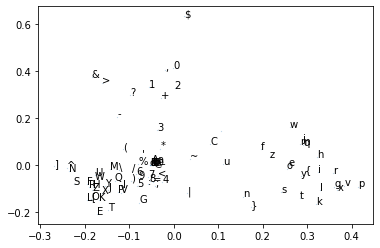

In [33]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], s=0.01)

val_min = np.min(list(prep.char_dict.values()))

for i, txt in cr.items():
    i2 = i - val_min
    plt.annotate(txt, (x[i2, 0], x[i2, 1]))

In [28]:
prep.char_dict

{'\n': 4,
 ' ': 5,
 '!': 6,
 '"': 7,
 '#': 8,
 '$': 9,
 '%': 10,
 '&': 11,
 "'": 12,
 '(': 13,
 ')': 14,
 '*': 15,
 '+': 16,
 ',': 17,
 '-': 18,
 '.': 19,
 '/': 20,
 '0': 21,
 '1': 22,
 '2': 23,
 '3': 24,
 '4': 25,
 '5': 26,
 '6': 27,
 '7': 28,
 '8': 29,
 '9': 30,
 ':': 31,
 ';': 32,
 '<': 33,
 '=': 34,
 '>': 35,
 '?': 36,
 '@': 37,
 'A': 38,
 'B': 39,
 'C': 40,
 'D': 41,
 'E': 42,
 'F': 43,
 'G': 44,
 'H': 45,
 'I': 46,
 'J': 47,
 'K': 48,
 'L': 49,
 'M': 50,
 'N': 51,
 'O': 52,
 'P': 53,
 'Q': 54,
 'R': 55,
 'S': 56,
 'T': 57,
 'U': 58,
 'V': 59,
 'W': 60,
 'X': 61,
 'Y': 62,
 'Z': 63,
 '[': 64,
 '\\': 65,
 ']': 66,
 '^': 67,
 '_': 68,
 '`': 69,
 'a': 70,
 'b': 71,
 'c': 72,
 'd': 73,
 'e': 74,
 'f': 75,
 'g': 76,
 'h': 77,
 'i': 78,
 'j': 79,
 'k': 80,
 'l': 81,
 'm': 82,
 'n': 83,
 'o': 84,
 'p': 85,
 'q': 86,
 'r': 87,
 's': 88,
 't': 89,
 'u': 90,
 'v': 91,
 'w': 92,
 'x': 93,
 'y': 94,
 'z': 95,
 '{': 96,
 '|': 97,
 '}': 98,
 '~': 99}

In [70]:
language_model_prerained = Model(ecle_base.embedder.input, final_conv)

In [71]:
language_model_prerained.save("models/prod/lm_pre.cnn")

In [74]:
prep.save("models/prod/lm/")

In [72]:
different = Model(new_conv, final_conv)

/home/jmf/miniconda3/envs/recipe/lib/python3.6/site-packages/keras/engine/network.py:180: UserWarning:

Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer dropout_3.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: dropout_3/cond/Merge:0



ValueError: Graph disconnected: cannot obtain value for tensor Tensor("ecle_inp:0", shape=(?, 128), dtype=float32) at layer "ecle_inp". The following previous layers were accessed without issue: []

Using TensorFlow backend.
